In [95]:
from ast import literal_eval

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
pd.options.display.max_rows = 999

In [27]:
def clean(x):
    return literal_eval(x)

In [28]:
accre_jobs = pd.read_csv('../data/accre_jobs_cleaned.csv', converters={'node_numbers': clean})

# Jason --
    Question: 2   CMS Frequency of failure on particular nodes - user names: "cmslocal" and "cmspilot"

The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot". For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes. Do any of their jobs that ended in under an hour also cluster on specific compute nodes, suggesting possbily unreliable systems? Check both “production” and “nogpfs” partitions. Look for commonly failing nodes and compare with other failed jobs.

In [87]:
plt.style.use('dark_background')

In [4]:
cms_jobs_df = accre_jobs[(accre_jobs['user'] == "cmslocal") | (accre_jobs['user'] == "cmspilot")]

In [5]:
total_jobs = cms_jobs_df.shape[0]

In [6]:
cms_jobs_df['failure'] = np.where(cms_jobs_df['exitcode'] == "0:0", 0, 1)

<ipython-input-6-ee7b4d49ef10>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cms_jobs_df['failure'] = np.where(cms_jobs_df['exitcode'] == "0:0", 0, 1)


In [7]:
cms_jobs_failed_df = cms_jobs_df[cms_jobs_df['failure'] == 1]

In [8]:
failures = cms_jobs_failed_df.shape[0]

In [9]:
failures / total_jobs * 100

0.027491310355378974

In [44]:
cms_jobs_df[cms_jobs_df['used_total_seconds'] < 1920].sort_values('used_total_seconds', ascending=False)

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,failure
1304086,1304086,19199513,cms,cmslocal,5000Mn,2236.99M,2-00:00:00,00:31:59,1,1,production,0:0,COMPLETED,cn1395,172800,1919,5000.000,cn,['1395'],0
1304068,1304068,19199489,cms,cmslocal,5000Mn,1841.12M,2-00:00:00,00:31:59,1,1,production,0:0,COMPLETED,cn1398,172800,1919,5000.000,cn,['1398'],0
1304071,1304071,19199492,cms,cmslocal,5000Mn,2256.19M,2-00:00:00,00:31:59,1,1,production,0:0,COMPLETED,cn1395,172800,1919,5000.000,cn,['1395'],0
3657914,3657914,23882247,cms,cmslocal,28000Mn,7668.51M,2-00:00:00,00:31:59,1,4,production,0:0,COMPLETED,cn355,172800,1919,7000.000,cn,['355'],0
3812155,3812155,24167068,cms,cmslocal,28000Mn,7482.70M,2-00:00:00,00:31:59,1,4,production,0:0,COMPLETED,cn1397,172800,1919,7000.000,cn,['1397'],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
661376,661376,17996040,cms,cmspilot,21875Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,ng1003,172800,0,2734.375,ng,['1003'],0
761639,761639,18104789,cms,cmspilot,21875Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,ng909,172800,0,2734.375,ng,['909'],0
761638,761638,18104788,cms,cmspilot,21880Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,ng914,172800,0,2735.000,ng,['914'],0
761637,761637,18104787,cms,cmspilot,21875Mn,0,2-00:00:00,00:00:00,1,8,nogpfs,0:0,COMPLETED,ng909,172800,0,2734.375,ng,['909'],0


In [126]:
cms_jobs_df['early_exit'] = np.where(cms_jobs_df['used_total_seconds'] < 1920, 1, 0)

In [127]:
early_exits_df = cms_jobs_df[cms_jobs_df['early_exit'] == 1]

In [128]:
early_exits = early_exits_df.shape[0]

In [129]:
early_exits

481093

In [14]:
early_exits / total_jobs * 100

57.50381292521885

In [64]:
node_early_exists = early_exits_df['nodelist'].value_counts()

In [65]:
node_jobs = cms_jobs_df['nodelist'].value_counts()

In [66]:
node_partition = cms_jobs_df[['nodelist', 'partition']].drop_duplicates().set_index('nodelist')

In [67]:
node_jobs_df = pd.concat([node_early_exists, node_jobs, node_partition], axis=1)

In [68]:
node_jobs_df

,nodelist,nodelist,partition
ng518,19346.0,19526,nogpfs
ng1078,6380.0,6542,nogpfs
ng1112,6164.0,6333,nogpfs
ng1040,5673.0,5854,nogpfs
ng1027,5639.0,5805,nogpfs
ng1003,5619.0,5801,nogpfs
ng507,5395.0,5566,nogpfs
ng1067,5346.0,5515,nogpfs
ng909,5158.0,5316,nogpfs
ng205,4686.0,4869,nogpfs


In [69]:
node_jobs_df.columns = ['early_exits', 'jobs', 'partition']

In [70]:
node_jobs_df['failure_percent'] = node_jobs_df['early_exits'] / node_jobs_df['jobs'] * 100

In [71]:
node_jobs_df['failure_percent'].describe()

count    818.000000
mean      50.708806
std       17.515431
min       14.285714
25%       39.908123
50%       45.521436
75%       53.057066
max      100.000000
Name: failure_percent, dtype: float64

In [72]:
high_failure_nodes = node_jobs_df[node_jobs_df['failure_percent'] > 53.057066].sort_values('failure_percent', ascending=False)

# Next Steps
- GO back and map high failure_nodes into the cms_jobs list and all the jobs and see if it dispropoiately fails.
- Map out failures by partition
- Map out failure clusters by order to job execution by order of job id

In [73]:
high_failure_nodes

,early_exits,jobs,partition,failure_percent
gpu0020,209.0,209,pascal,100.000000
gpu0032,31.0,31,pascal,100.000000
gpu0019,12.0,12,pascal,100.000000
gpu0026,15.0,15,pascal,100.000000
gpu0031,19.0,19,pascal,100.000000
gpu0015,20.0,20,pascal,100.000000
gpu0034,21.0,21,pascal,100.000000
gpu0014,23.0,23,pascal,100.000000
gpu0018,26.0,26,pascal,100.000000
gpu0021,26.0,26,pascal,100.000000


In [85]:
partition_failures = high_failure_nodes.groupby('partition').agg({'early_exits':['count']})

# upper quartile failures by partition

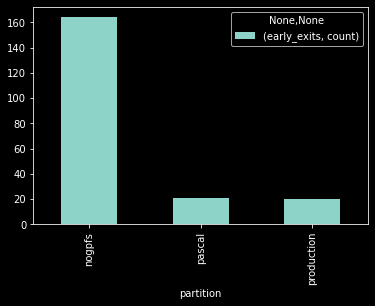

In [89]:
partition_failures.plot(kind='bar');

In [93]:
overall_partitions = node_jobs_df.groupby('partition').agg({'early_exits': 'sum', 'jobs': 'sum'})

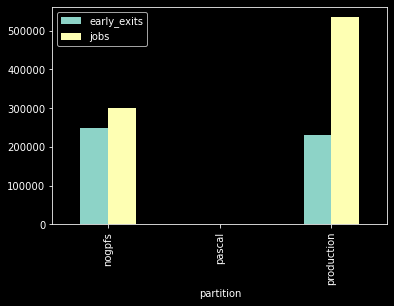

In [94]:
overall_partitions.plot(kind='bar');

In [99]:
cms_jobs_df

,Unnamed: 0,jobid,account,user,reqmem,usedmem,reqtime,usedtime,nodes,cpus,partition,exitcode,state,nodelist,req_total_seconds,used_total_seconds,mb_per_core,node_index,node_numbers,failure
2125,2125,17032244,cms,cmspilot,28000Mn,8320.07M,2-00:00:00,1-23:31:46,1,4,production,0:0,COMPLETED,cn1205,172800,171106,7000.000,cn,['1205'],0
2126,2126,17032568,cms,cmspilot,28000Mn,11954.84M,2-00:00:00,1-23:33:13,1,4,production,0:0,COMPLETED,cn1492,172800,171193,7000.000,cn,['1492'],0
2127,2127,17032569,cms,cmspilot,28000Mn,10498.84M,2-00:00:00,1-23:36:36,1,4,production,0:0,COMPLETED,cn1497,172800,171396,7000.000,cn,['1497'],0
2128,2128,17032916,cms,cmspilot,21875Mn,11728.02M,2-00:00:00,1-23:27:55,1,8,nogpfs,0:0,COMPLETED,ng1037,172800,170875,2734.375,ng,['1037'],0
2129,2129,17032920,cms,cmspilot,94451Mn,20659.08M,2-00:00:00,1-23:16:04,1,8,nogpfs,0:0,COMPLETED,ng691,172800,170164,11806.375,ng,['691'],0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3815978,3815978,24173154,cms,cmspilot,28000Mn,0,2-00:00:00,00:06:41,1,4,production,0:0,RUNNING,cn461,172800,401,7000.000,cn,['461'],0
3815979,3815979,24173155,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1516,172800,244,7000.000,cn,['1516'],0
3815980,3815980,24173156,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1524,172800,244,7000.000,cn,['1524'],0
3815981,3815981,24173158,cms,cmspilot,28000Mn,0,2-00:00:00,00:04:04,1,4,production,0:0,RUNNING,cn1532,172800,244,7000.000,cn,['1532'],0


In [114]:
import math

def index_marks(nrows, chunk_size):
    return range(chunk_size, math.ceil(nrows / chunk_size) * chunk_size, chunk_size)

In [115]:
def split(dfm, chunk_size):
    indices = index_marks(dfm.shape[0], chunk_size)
    return np.split(dfm, indices)

In [152]:
chunked = []

In [153]:
chunks = split(cms_jobs_df, 10000)
for idx, chunk in enumerate(chunks):
    chunked.append(chunk.groupby('partition').agg({'early_exit':sum, 'jobid':'count'}).assign(chunk=idx))

In [154]:
chunked

[            early_exit  jobid  chunk
 partition                           
 nogpfs            3522   4225      0
 production         493   5775      0,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4314   4928      1
 production         714   5072      1,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4419   4874      2
 production         654   5126      2,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4435   5046      3
 production         630   4954      3,
             early_exit  jobid  chunk
 partition                           
 nogpfs            6738   7276      4
 production         827   2724      4,
             early_exit  jobid  chunk
 partition                           
 nogpfs            4313   4976      5
 production         410   5024      5,
             early_exit  jobid  chunk
 partition                           
 nogpf

In [161]:
failures_by_chunk = pd.concat(chunked)

In [162]:
failures_by_chunk = failures_by_chunk.reset_index()

In [163]:
failures_by_chunk

,partition,early_exit,jobid,chunk
0,nogpfs,3522,4225,0
1,production,493,5775,0
2,nogpfs,4314,4928,1
3,production,714,5072,1
4,nogpfs,4419,4874,2
5,production,654,5126,2
6,nogpfs,4435,5046,3
7,production,630,4954,3
8,nogpfs,6738,7276,4
9,production,827,2724,4


In [164]:
failures_by_chunk.columns = ['partition', 'failed', 'total', 'chunk']

In [151]:
px.line(failures_by_chunk.reset_index(), x='chunk', y='early_exit', 
        line_group='partition', color='partition')

In [ ]:
accre_jobs_failed_nodesplit = pd.DataFrame(
    {col: np.repeat(accre_jobs_failed[col].values,accre_jobs_failed['node_numbers'].str.len())
             for col in accre_jobs_failed.columns.drop('node_numbers')}).assign(**{'node_numbers': np.concatenate(accre_jobs_failed['node_numbers'].values)})